In [1]:
import pandas as pd
import numpy as np
import bisect
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

import matplotlib.pyplot as plt

In [2]:
data_path = './data/train.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Label distribution

In [5]:
df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0, 0.5, 'frequency')

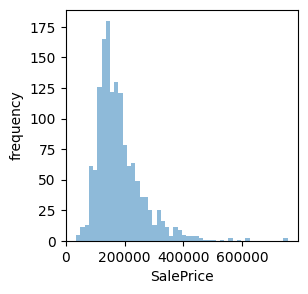

In [6]:
fig, ax = plt.subplots(figsize=(3,3))
df["SalePrice"].hist(bins=50, grid=False, alpha=.5, ax=ax)
ax.set_xlabel("SalePrice")
ax.set_ylabel("frequency")

In [7]:
max_SalePrice = df[["SalePrice"]].quantile(.95, method="table", interpolation="nearest").values[0]
print(f"max_SalePrice: {max_SalePrice}")

# df.loc[df["SalePrice"] > max_SalePrice, "SalePrice"] = max_SalePrice
df = df[df["SalePrice"] <= max_SalePrice]

max_SalePrice: 326000


Text(0, 0.5, 'frequency')

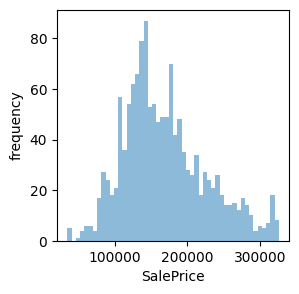

In [8]:
fig, ax = plt.subplots(figsize=(3,3))
df["SalePrice"].hist(bins=50, grid=False, alpha=.5, ax=ax)
ax.set_xlabel("SalePrice")
ax.set_ylabel("frequency")

Text(0, 0.5, 'frequency')

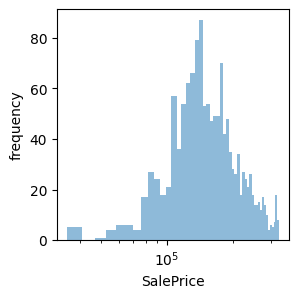

In [9]:
fig, ax = plt.subplots(figsize=(3,3))
df["SalePrice"].hist(bins=50, grid=False, alpha=.5, ax=ax)
ax.set_xscale("log")
ax.set_xlabel("SalePrice")
ax.set_ylabel("frequency")

In [10]:
def print_list_in_batches(lst, batch):
    for idx in range(0, len(lst), batch):
        print(lst[idx : idx + batch])

In [11]:
def label_transform(y):
    return np.log(1 + y)

def inverse_label_transform(yt):
    return np.exp(yt) - 1

def log_numerical(x):
    if not pd.isnull(x):
        return np.log(1 + x)
    
def log_bin_numerical(x):
    if pd.isnull(x):
        return "-1"
    elif x == 0:
        return "zero"
    else:
        return np.log(x)


In [12]:
# Custom imputation functions
def compute_numerical_imputation_values(df, features):
    return df[features].mean(skipna=True).to_dict() 

def compute_categorical_imputation_values(df, features):
    return df[features].mode(axis=0).iloc[0].to_dict()

def compute_imputation_values(df, categorical_features=[], numerical_features=[]):
    numerical_imputation_map = compute_numerical_imputation_values(df, numerical_features)
    categorical_imputation_map = compute_categorical_imputation_values(df, categorical_features)
    return {
        **numerical_imputation_map, 
        **categorical_imputation_map
    }

def fill_missing_values(df, imputation_map):
    for col, val in imputation_map.items():
        df[col] = df[col].fillna(val)
    return df

### Label transformation

In [13]:
df["SalePrice"] = df["SalePrice"].apply(label_transform)

### Feature analysis

In [14]:
# Missing value %
missing_pct = (100 * (df.isna().sum() / len(df)).sort_values(ascending=False)).to_dict()
missing_pct = {k: v for k, v in missing_pct.items() if v > 0}
missing_pct

{'PoolQC': 99.56741167988464,
 'MiscFeature': 96.10670511896178,
 'Alley': 93.43907714491708,
 'Fence': 80.02883922134102,
 'MasVnrType': 61.86012977649603,
 'FireplaceQu': 49.603460706560924,
 'LotFrontage': 18.385003604902668,
 'GarageQual': 5.839942321557317,
 'GarageFinish': 5.839942321557317,
 'GarageType': 5.839942321557317,
 'GarageYrBlt': 5.839942321557317,
 'GarageCond': 5.839942321557317,
 'BsmtFinType2': 2.73972602739726,
 'BsmtExposure': 2.73972602739726,
 'BsmtCond': 2.6676279740447004,
 'BsmtQual': 2.6676279740447004,
 'BsmtFinType1': 2.6676279740447004,
 'MasVnrArea': 0.5046863734679163,
 'Electrical': 0.07209805335255948}

In [15]:
df["PoolQC"].value_counts()

PoolQC
Gd    3
Fa    2
Ex    1
Name: count, dtype: int64

In [16]:
# Augment features
df["Age"] = (df["YrSold"] - df["YearBuilt"]).apply(lambda x: max(0, x))
df["RemodelAge"] = (df["YrSold"] - df["YearRemodAdd"]).apply(lambda x: max(0, x))
df["GarageAge"] = (df["YrSold"] - df["GarageYrBlt"]).apply(lambda x: max(0, x))

In [17]:
features = [cn for cn in df.columns if cn not in {"Id", "SalePrice", "YearBuilt", "YearRemodAdd", "GarageYrBlt"}]

In [18]:
categorical_features = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
    'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
    'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
    'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
    'MoSold', 'SaleType', 'SaleCondition', 'YrSold'
]

print_list_in_batches(categorical_features, batch=5)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape']
['LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood']
['Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual']
['OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd']
['MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation']
['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
['Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual']
['Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual']
['GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature']
['MoSold', 'SaleType', 'SaleCondition', 'YrSold']


In [19]:
numerical_features = [x for x in features if x not in categorical_features]
df.loc[:, numerical_features] = df[numerical_features].apply(pd.to_numeric)

print_list_in_batches(numerical_features, batch=5)

['LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr']
['KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea']
['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
['PoolArea', 'MiscVal', 'Age', 'RemodelAge', 'GarageAge']


In [20]:
for fn in numerical_features:
    print(f"{fn}: {df[fn].min()} -- {df[fn].max()}")

LotFrontage: 21.0 -- 313.0
LotArea: 1300 -- 164660
BsmtFinSF1: 0 -- 5644
BsmtFinSF2: 0 -- 1474
BsmtUnfSF: 0 -- 2042
TotalBsmtSF: 0 -- 6110
1stFlrSF: 334 -- 4692
2ndFlrSF: 0 -- 1818
LowQualFinSF: 0 -- 528
GrLivArea: 334 -- 5642
BsmtFullBath: 0 -- 3
BsmtHalfBath: 0 -- 2
FullBath: 0 -- 3
HalfBath: 0 -- 2
BedroomAbvGr: 0 -- 8
KitchenAbvGr: 0 -- 3
TotRmsAbvGrd: 2 -- 14
Fireplaces: 0 -- 3
GarageCars: 0 -- 4
GarageArea: 0 -- 1418
WoodDeckSF: 0 -- 736
OpenPorchSF: 0 -- 547
EnclosedPorch: 0 -- 552
3SsnPorch: 0 -- 508
ScreenPorch: 0 -- 480
PoolArea: 0 -- 738
MiscVal: 0 -- 15500
Age: 0 -- 136
RemodelAge: 0 -- 60
GarageAge: 0.0 -- 107.0


In [21]:
log_transformed_features = [
    "LotFrontage", "LotArea", "BsmtFinSF1",
    "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
    "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF",
    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"
]

log_bin_transformed_features = ["Age", "RemodelAge", "GarageAge"]

In [22]:
rem_numerical_features = [
    fn for fn in numerical_features 
    if fn not in log_transformed_features
    and fn not in log_bin_transformed_features
]
print_list_in_batches(rem_numerical_features, batch=5)

['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr']
['KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']


In [23]:
df[rem_numerical_features].head()

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars
0,1,0,2,1,3,1,8,0,2
1,0,1,2,0,3,1,6,1,2
2,1,0,2,1,3,1,6,1,2
3,1,0,1,0,3,1,7,1,3
4,1,0,2,1,4,1,9,1,3


In [24]:
for fn in rem_numerical_features:
    print(f"{fn}: {df[fn].min()} -- {df[fn].max()}")

BsmtFullBath: 0 -- 3
BsmtHalfBath: 0 -- 2
FullBath: 0 -- 3
HalfBath: 0 -- 2
BedroomAbvGr: 0 -- 8
KitchenAbvGr: 0 -- 3
TotRmsAbvGrd: 2 -- 14
Fireplaces: 0 -- 3
GarageCars: 0 -- 4


In [25]:
df.isna().sum().to_dict()

{'Id': 0,
 'MSSubClass': 0,
 'MSZoning': 0,
 'LotFrontage': 255,
 'LotArea': 0,
 'Street': 0,
 'Alley': 1296,
 'LotShape': 0,
 'LandContour': 0,
 'Utilities': 0,
 'LotConfig': 0,
 'LandSlope': 0,
 'Neighborhood': 0,
 'Condition1': 0,
 'Condition2': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'RoofStyle': 0,
 'RoofMatl': 0,
 'Exterior1st': 0,
 'Exterior2nd': 0,
 'MasVnrType': 858,
 'MasVnrArea': 7,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinSF1': 0,
 'BsmtFinType2': 38,
 'BsmtFinSF2': 0,
 'BsmtUnfSF': 0,
 'TotalBsmtSF': 0,
 'Heating': 0,
 'HeatingQC': 0,
 'CentralAir': 0,
 'Electrical': 1,
 '1stFlrSF': 0,
 '2ndFlrSF': 0,
 'LowQualFinSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 0,
 'BsmtHalfBath': 0,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'KitchenQual': 0,
 'TotRmsAbvGrd': 0,
 'Functional': 0,
 'F

In [26]:
target_column = "SalePrice"
all_features = categorical_features + log_transformed_features + log_bin_transformed_features + rem_numerical_features

In [27]:
df[all_features].isnull().sum().to_dict()

{'MSSubClass': 0,
 'MSZoning': 0,
 'Street': 0,
 'Alley': 1296,
 'LotShape': 0,
 'LandContour': 0,
 'Utilities': 0,
 'LotConfig': 0,
 'LandSlope': 0,
 'Neighborhood': 0,
 'Condition1': 0,
 'Condition2': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'RoofStyle': 0,
 'RoofMatl': 0,
 'Exterior1st': 0,
 'Exterior2nd': 0,
 'MasVnrType': 858,
 'MasVnrArea': 7,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinType2': 38,
 'Heating': 0,
 'HeatingQC': 0,
 'CentralAir': 0,
 'Electrical': 1,
 'KitchenQual': 0,
 'Functional': 0,
 'FireplaceQu': 688,
 'GarageType': 81,
 'GarageFinish': 81,
 'GarageQual': 81,
 'GarageCond': 81,
 'PavedDrive': 0,
 'PoolQC': 1381,
 'Fence': 1110,
 'MiscFeature': 1333,
 'MoSold': 0,
 'SaleType': 0,
 'SaleCondition': 0,
 'YrSold': 0,
 'LotFrontage': 255,
 'LotArea': 0,
 'BsmtFinSF1': 0,
 'BsmtFinSF2': 0,
 'BsmtUnfSF': 0,
 'TotalBsmtSF': 0,
 '1stFlrSF': 0

In [28]:
keep_columns = all_features + [target_column]

In [29]:
# Split into train and test sets
df_train, df_test = train_test_split(df[keep_columns], test_size=0.2, random_state=42)

In [30]:
# Separate features and target
X_train = df_train.drop(columns=[target_column])
y_train = df_train[target_column]
X_test = df_test.drop(columns=[target_column])
y_test = df_test[target_column]

In [31]:
imputation_map = compute_imputation_values(
    X_train, 
    categorical_features=categorical_features, 
    numerical_features=log_transformed_features + rem_numerical_features
)

print(imputation_map)

{'LotFrontage': 69.33661202185792, 'LotArea': 10020.197475202885, 'BsmtFinSF1': 418.4652840396754, 'BsmtFinSF2': 46.30297565374211, 'BsmtUnfSF': 555.5770964833183, 'TotalBsmtSF': 1020.3453561767358, '1stFlrSF': 1126.4544634806132, '2ndFlrSF': 339.28133453561765, 'LowQualFinSF': 6.881875563570785, 'GrLivArea': 1472.6176735798017, 'GarageArea': 459.0135256988278, 'WoodDeckSF': 87.95401262398558, 'OpenPorchSF': 44.67899008115419, 'EnclosedPorch': 22.064021641118124, '3SsnPorch': 3.5680793507664563, 'ScreenPorch': 15.030658250676286, 'PoolArea': 3.1316501352569883, 'MiscVal': 50.685302073940484, 'BsmtFullBath': 0.4012623985572588, 'BsmtHalfBath': 0.06492335437330929, 'FullBath': 1.545536519386835, 'HalfBath': 0.36880072137060416, 'BedroomAbvGr': 2.8584310189359785, 'KitchenAbvGr': 1.0513976555455364, 'TotRmsAbvGrd': 6.403065825067628, 'Fireplaces': 0.5960324616771867, 'GarageCars': 1.7141568981064021, 'MSSubClass': 20, 'MSZoning': 'RL', 'Street': 'Pave', 'Alley': 'Grvl', 'LotShape': 'Reg',

In [32]:
def prepare_lightgbm_categorical(df, features):
    # Convert categorical features to the appropriate types
    for fn in features:
        if df[fn].dtype == 'bool':
            # Convert boolean features to int
            df[fn] = df[fn].astype(int)
        else:
            # For string categorical features, set dtype as 'category'
            df[fn] = df[fn].astype('category')
    return df

def many_log_bin_numerical(df, features):
    for fn in features:
        df[fn] = df[fn].apply(log_bin_numerical)
    return df

def many_log_numerical(df, features):
    for fn in features:
        df[fn] = df[fn].apply(log_numerical)
    return df

In [33]:
X_train = fill_missing_values(X_train, imputation_map)
X_test = fill_missing_values(X_test, imputation_map)

In [34]:
X_train = many_log_bin_numerical(X_train, log_bin_transformed_features)
X_train = many_log_numerical(X_train, log_transformed_features)
X_train = prepare_lightgbm_categorical(X_train, categorical_features + log_bin_transformed_features)

X_test = many_log_bin_numerical(X_test, log_bin_transformed_features)
X_test = many_log_numerical(X_test, log_transformed_features)
X_test = prepare_lightgbm_categorical(X_test, categorical_features + log_bin_transformed_features)

In [35]:
# Prepare LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features, reference=train_data, free_raw_data=False)

In [36]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_pre_filter': False  # Avoid errors with categorical features
}

# Train LightGBM model with callbacks
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],  # Validation sets
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # Early stopping
        lgb.log_evaluation(period=10)           # Log evaluation every 10 iterations
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2993
[LightGBM] [Info] Number of data points in the train set: 1109, number of used features: 79
[LightGBM] [Info] Start training from score 11.982134
Training until validation scores don't improve for 50 rounds
[10]	train's l2: 0.0548089	test's l2: 0.0704741
[20]	train's l2: 0.0285041	test's l2: 0.0432521
[30]	train's l2: 0.0169086	test's l2: 0.0307865
[40]	train's l2: 0.0113411	test's l2: 0.0250937
[50]	train's l2: 0.0084561	test's l2: 0.0222632
[60]	train's l2: 0.00669545	test's l2: 0.0206948
[70]	train's l2: 0.00550373	test's l2: 0.0195782
[80]	train's l2: 0.00468034	test's l2: 0.0189546
[90]	train's l2: 0.00404658	test's l2: 0.0185872
[100]	train's l2: 0.00353539	test's l2: 0.0184577
[110]	train's l2: 0.00309537	test's l2: 0.0182776
[120]	train's l2: 0.00272825	test's l2: 0.0181534
[130]	train

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
r2_score_ = r2_score(y_test, y_pred)
print(f"Final Test R2: {r2_score_:.4f}")

Final Test AUC: 0.8720


In [38]:
# Feature importance
importance = model.feature_importance(importance_type='gain')
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)
display(feature_importance)

,Feature,Importance
14,OverallQual,371.682809
58,GrLivArea,212.729993
9,Neighborhood,208.805372
54,TotalBsmtSF,88.898171
59,GarageArea,54.749420
...,...,...
42,PoolQC,0.000000
57,LowQualFinSF,0.000000
65,PoolArea,0.000000
66,MiscVal,0.000000


### Hyperparameter tuning

In [39]:
# Define objective function for Optuna
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 5, 20),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
    }

    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)

    # Train LightGBM model with callbacks
    model = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, valid_data],  # Validation sets
        valid_names=['train', 'valid'],
        # verbose_eval=False,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),  # Early stopping
            lgb.log_evaluation(period=100)           # Log evaluation every 10 iterations
        ]
    )

    preds = model.predict(X_test)
    r2_score_ = r2_score(y_test, preds)
    return r2_score_

In [40]:
# Optimize hyperparameters
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-11-29 04:40:21,978] A new study created in memory with name: no-name-d595c742-3608-470b-a72d-7ef573f4dc74


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	train's l2: 0.0480552	valid's l2: 0.0622732
Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.0480552	valid's l2: 0.0622732
[I 2024-11-29 04:40:25,148] Trial 0 finished with value: 0.5524306962038267 and parameters: {'learning_rate': 0.008468008575248327, 'num_leaves': 20, 'max_depth': 6, 'min_child_samples': 32, 'min_child_weight': 0.0029380279387035343, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 2.9154431891537547, 'reg_lambda': 0.2537815508265665}. Best is trial 0 with value: 0.5524306962038267.
Training until validation scores don't improve for 50 rounds
[100]	train's l2: 0.0113668	valid's l2: 0.0182755
Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.0113668	valid's l2: 0.0182755
[I 2024-11-29 04:40:25,749] Trial 1 finished with value: 0.8686508303451437 and parameters: {'learning_rate': 0.05675206026988748, 'num_leaves': 5, 'max_depth'

In [41]:
# Best hyperparameters
print("Best R2 Score:", study.best_value)
print("Best Parameters:", study.best_params)

# Train the final model with best parameters
best_params = study.best_params
best_params["objective"] = "regression"
best_params["metric"] = "mse"
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

Best R2 Score: 0.8830492498933261
Best Parameters: {'learning_rate': 0.09359980324420485, 'num_leaves': 19, 'max_depth': 4, 'min_child_samples': 22, 'min_child_weight': 0.0019140171266136662, 'subsample': 0.789140070498087, 'colsample_bytree': 0.517971136898371, 'reg_alpha': 0.0728437126516689, 'reg_lambda': 0.14810800730363496}


In [42]:
final_model = lgb.train(
        best_params,
        train_data,
        num_boost_round=5000,
        valid_sets=[train_data, valid_data],  # Validation sets
        valid_names=['train', 'valid'],
        # verbose_eval=False,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),  # Early stopping
            lgb.log_evaluation(period=10)           # Log evaluation every 10 iterations
        ]
    )

Training until validation scores don't improve for 100 rounds
[10]	train's l2: 0.0368504	valid's l2: 0.0501012
[20]	train's l2: 0.0176919	valid's l2: 0.0282188
[30]	train's l2: 0.012003	valid's l2: 0.0215093
[40]	train's l2: 0.0096245	valid's l2: 0.0188021
[50]	train's l2: 0.00832409	valid's l2: 0.0176209
[60]	train's l2: 0.00738229	valid's l2: 0.016949
[70]	train's l2: 0.00658531	valid's l2: 0.0165796
[80]	train's l2: 0.00601311	valid's l2: 0.0163601
[90]	train's l2: 0.00549703	valid's l2: 0.0163459
[100]	train's l2: 0.00514358	valid's l2: 0.0163342
[110]	train's l2: 0.00473671	valid's l2: 0.0164728
[120]	train's l2: 0.00443697	valid's l2: 0.0164115
[130]	train's l2: 0.00414503	valid's l2: 0.0165389
[140]	train's l2: 0.00387176	valid's l2: 0.0165878
[150]	train's l2: 0.00362637	valid's l2: 0.0166294
[160]	train's l2: 0.0033941	valid's l2: 0.0165553
[170]	train's l2: 0.00314493	valid's l2: 0.0166481
[180]	train's l2: 0.00292234	valid's l2: 0.0167112
[190]	train's l2: 0.0027405	valid's 

In [43]:
# Predict on the test set
y_pred = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred)
print("Final R2:", final_r2)

Final R2: 0.8830492498933261


In [44]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

0.12756222906126163


### TO DO
